# TP4 : Improve the Metropolis-Hastings algorithm

In [496]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.stats import invgamma

# Exercice 1 - Adaptive Metropolis-Hastings algorithm

## 1.A Metropolis Hastings within Gibbs sampler

### Question 1

In this part, I define the asked methods sample_from_P1, sample_from_P2 and HMWG which calls the two first methods. This parts works in dimension $2$ on the defined target $\pi$. 

A more general code for MHWG (and then Adaptive-MHWG) is available in 1.B Question 2 where I generalize the code for any target density in any dimension.

In [430]:
# Target distribution pi
def log_pi(x,y,a):
    return -(x/a)**2-y**2-0.25*((x/a)**2-y**2)**2

# Sample from P1
def sample_from_P1(x,y, a, sigma1):
    z1 = np.random.normal(x, sigma1)
    accept_ratio = np.exp(np.min([0, log_pi(z1,y,a) - log_pi(x,y,a)]))
    boolean_accepted = True # Boolean indicated if the new point is accepted 
    if np.random.rand() > accept_ratio:
        z1 = x
        boolean_accepted = False
    return z1, y, accept_ratio, boolean_accepted

# Sample from P2
def sample_from_P2(x,y, a, sigma2):
    z2 = np.random.normal(y, sigma2)
    accept_ratio = np.exp(np.min([0, log_pi(x,z2,a) - log_pi(x,y,a)]))
    boolean_accepted = True # Boolean indicated if the new point is accepted 
    if np.random.rand() > accept_ratio:
        z2 = y
        boolean_accepted = False
    return x, z2, accept_ratio, boolean_accepted 

In [431]:
# This method applies only to target distribution pi. A more general algorithm is implemented in 1.B.2

def MHWG(a, sigma1, sigma2, n_iter, x0=None, y0=None):
    Accept_rate_x = []
    Accept_rate_y = []
    Accept_attempts_x = [0,0] # Will contain the number of time transition was accepted and the number of attempts
    Accept_attempts_y = [0,0] # Same for y
    Samples = []

    # Initialization
    if x0 is None:
        x = np.random.randn()
    else:
        x = x0
    if y0 is None:
        y = np.random.randn()
    else:
        y = y0

    for n in trange(n_iter):
        if np.random.rand()<0.5: # Then MH on the first coordinate 
            x, y, accept_rate, boolean_accepted = sample_from_P1(x, y, a, sigma1)
            Accept_rate_x.append(accept_rate)
            if boolean_accepted:
                Accept_attempts_x[0] +=1
            Accept_attempts_x[1] +=1
        else: # Otherwise MH on the second coordinate 
            x, y, accept_rate, boolean_accepted = sample_from_P2(x, y, a, sigma2)
            Accept_rate_y.append(accept_rate)
            if boolean_accepted:
                Accept_attempts_y[0] +=1
            Accept_attempts_y[1] +=1
        Samples.append([x,y])

    print("Acceptance rate on x =", Accept_attempts_x[0]/Accept_attempts_x[1])
    print("Acceptance rate on y =", Accept_attempts_y[0]/Accept_attempts_y[1])

    return np.array(Samples), Accept_rate_x, Accept_rate_y

### Question 2

In [432]:
# Numerical parameters
a = 10
sigma1 = 3
sigma2 = 3
n_iter = 1000

First, I plot the 1000 samples generated with the MHWG algorithm on a graph with the target distribution $\pi$.

The algorithm returns the acceptance rate on the two coordinates $x$ and $y$, which are calculated as the number of time the sample from the Gaussian distribution $q$ was accepted divided by the number of attempts (since in the Gibbs algorithm, at each iteration we sample from coordinate $x$ or $y$).

100%|██████████| 1000/1000 [00:00<00:00, 56584.97it/s]


Acceptance rate on x = 0.8557114228456913
Acceptance rate on y = 0.21357285429141717


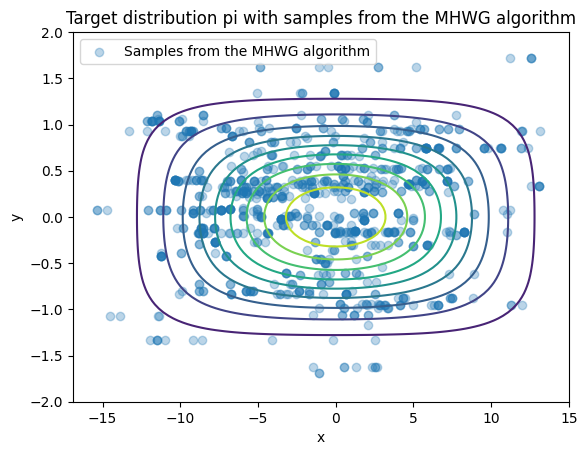

In [433]:
Samples, Accept_rate_x, Accept_rate_y = MHWG(a, sigma1, sigma2, n_iter)

x = np.linspace(-15, 15, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = np.exp(log_pi(X, Y, a))

plt.scatter(Samples[:, 0], Samples[:, 1], alpha = 0.3, label='Samples from the MHWG algorithm')
plt.contour(X, Y, Z, cmap='viridis', levels=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Target distribution pi with samples from the MHWG algorithm')
plt.legend()
plt.show()


Then I implement a function to calculate the cross correlation and plot $Corr(x,x)$, $Corr(x,y)$ and $Corr(y,y)$.

As we want to sample independent samples, we expect that those correlations converges to $0$ and quickly enough.

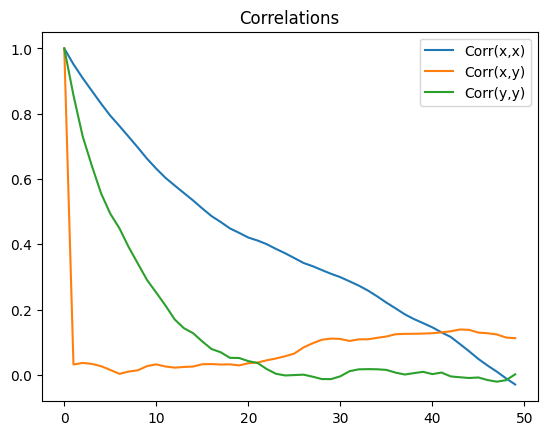

In [434]:
def crosscorr(x,y,max_lag=None):
    if max_lag is None:
        max_lag=len(x)
    sx=pd.Series(x)
    sy=pd.Series(y)
    res=np.zeros(max_lag)
    for lag in range(1,max_lag):
        res[lag]=sx.corr(sy.shift(lag))
    res[0]=1
    return res

plt.plot(crosscorr(Samples[:,0], Samples[:,0], max_lag = 50), label = "Corr(x,x)")
plt.plot(crosscorr(Samples[:,0], Samples[:,1], max_lag = 50), label = "Corr(x,y)")
plt.plot(crosscorr(Samples[:,1], Samples[:,1], max_lag = 50), label = "Corr(y,y)")
plt.title('Correlations')
plt.legend()

**Observations and conclusions :**
- First, the samples are close to the distribution $\pi$ so it seems that the MHWG permits to generate from our target distribution.
- However, the we can see "lines" of samples that are aligned on a same $y$ axis. The acceptance rate of $x$ is about $88\%$ and the one of $y$ is about $27\%$. Hence, the new coordinate $x$ is more likely to be accepted than a new $y$. This unbalanced proportion of $x/y$ transition leads to samples that are stucked along $y$ lines.
- On the cross correlation diagram, we can observe that the autocorrelation of $x$ does not converge toward 0 (or at leat at a very low pace). This is again due to the fact that the acceptance rate of $x$ is very high.

### Question 3

- A first improvement would be to change the values of $\sigma_i^2$.

The two chosen variances $\sigma_1^2$ and $\sigma_2^2$ are equal even though the target distribution $\pi$ is anysotropic. Here $\sigma_1^2$ is too small because we don't take into account the value of $a$. If we change $\sigma_1^2$ by $\sigma_1^2 * a$, the two variances are now symetric, leading to better autocorrelations and the disparition of the "lines" phenomenom on the scatter plot.

We can see in the following that the acceptation rate in $x$ has dropped and is now around $23\%$.

Note that the convergence of the autocorrelation towards $0$ is still slow.


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 41081.16it/s]


Acceptance rate on x = 0.2634730538922156
Acceptance rate on y = 0.20841683366733466


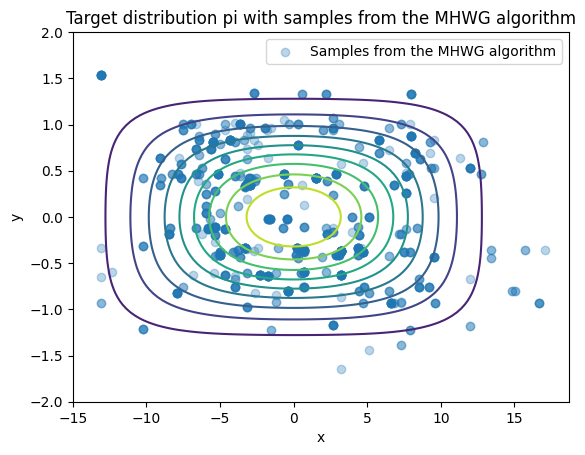

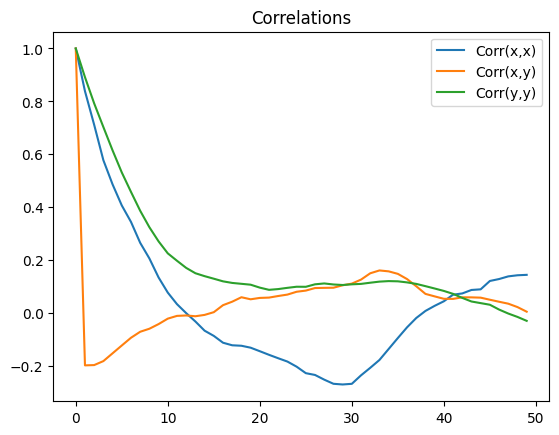

In [435]:
# Numerical parameters
a = 10
sigma1 = 3*10
sigma2 = 3
n_iter = 1000

Samples, Accept_rate_x, Accept_rate_y = MHWG(a, sigma1, sigma2, n_iter)

def plot_1():
    x = np.linspace(-15, 15, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.exp(log_pi(X, Y, a))

    plt.scatter(Samples[:, 0], Samples[:, 1], alpha = 0.3, label='Samples from the MHWG algorithm')
    plt.contour(X, Y, Z, cmap='viridis', levels=10)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Target distribution pi with samples from the MHWG algorithm')
    plt.legend()
    plt.show()

    plt.plot(crosscorr(Samples[:,0], Samples[:,0], max_lag = 50), label = "Corr(x,x)")
    plt.plot(crosscorr(Samples[:,0], Samples[:,1], max_lag = 50), label = "Corr(x,y)")
    plt.plot(crosscorr(Samples[:,1], Samples[:,1], max_lag = 50), label = "Corr(y,y)")
    plt.title('Correlations')
    plt.legend()
plot_1()

- Another solution would be to use a 2 dimension kernel to propose now $(x,y)$ points simultaneously, instead of updating $x$ and $y$ separately (Gibbs method). It would avoid the apparition of "lines" since there will not be sequential updates anymore.

We would define a covariance matrix $\Sigma$. We would have to find an appropriate value of $\Sigma$ to control the balance of the acceptance rate (as seen in class around $23\%$) and to reduce the autocorrelations of the samples.

## 1.B Adaptive Metropolis-Hastings within Gibbs sampler

### Question 1

In [436]:
# This method applies only to target distribution pi. A more general algorithm is implemented in 1.B.2
def Adaptive_MHWG(a, n_batch, batch_size, x0=None, y0=None):
    Accepts = np.zeros((n_batch, 2)) # Nb of time new x (resp y) was accepted for each batch
    Samples = []
    L = np.zeros((n_batch, 2))

    # Initialization
    if x0 is None:
        x = np.random.randn()
    else:
        x = x0
    if y0 is None:
        y = np.random.randn()
    else:
        y = y0

    for j in trange(n_batch):
        # Metropolis-Hastings within Gibbs step
        for k in range(batch_size):
            sigma1 = np.exp(L[j-1,0])
            x, y, accept_rate, boolean_accepted = sample_from_P1(x, y, a, sigma1)
            if boolean_accepted:
                Accepts[j,0] +=1
            Samples.append([x,y])
            
            sigma2 = np.exp(L[j-1,1])
            x, y, accept_rate, boolean_accepted = sample_from_P2(x, y, a, sigma2)
            if boolean_accepted:
                Accepts[j,1] +=1
            Samples.append([x,y])
        Accepts[j] = Accepts[j]/batch_size

        # Update the variance parameters l1 and l2
        delta = min(0.01, 1/np.sqrt(j+1))
        # Update L1 for the first coordinate 
        if Accepts[j,0] > 0.234:
            L[j,0] = L[j-1,0] + delta
        else:
            L[j,0] = L[j-1,0] - delta

        # Update L2 for the second coordinate
        if Accepts[j,1] > 0.234:
            L[j,1] = L[j-1,1] + delta
        else:
            L[j,1] = L[j-1,1] - delta

    return np.array(Samples), Accepts, L

In the following, I run the two algorithm (MHWG with $\sigma_1 = 10 \sigma_2$ and Adaptive MHWG). 

I will first analyse the results of Adaptive-MHWG:
- Comparison of the scatter plot of samples and the target distribution
- Evolution of log-variances for $x$ and $y$
- Evolution of the acceptance rate on $x$ and $y$

Then I will compare the two methods on the autocorrelation of $x$ and $y$.

In [437]:
# Numerical parameters
a = 10

# Adaptive MHWG
n_batch = 1000
batch_size = 50

# Non adaptive MHWG
sigma1 = 3*10
sigma2 = 3
n_iter = 50000

In [438]:
Samples, Accept_rate_x, Accept_rate_y = MHWG(a, sigma1, sigma2, n_iter)
Adapt_Samples, Adapt_Accepts, L = Adaptive_MHWG(a, n_batch, batch_size)


100%|██████████| 50000/50000 [00:00<00:00, 73461.25it/s]


Acceptance rate on x = 0.26234419942473636
Acceptance rate on y = 0.26025312399871836


100%|██████████| 1000/1000 [00:03<00:00, 327.73it/s]


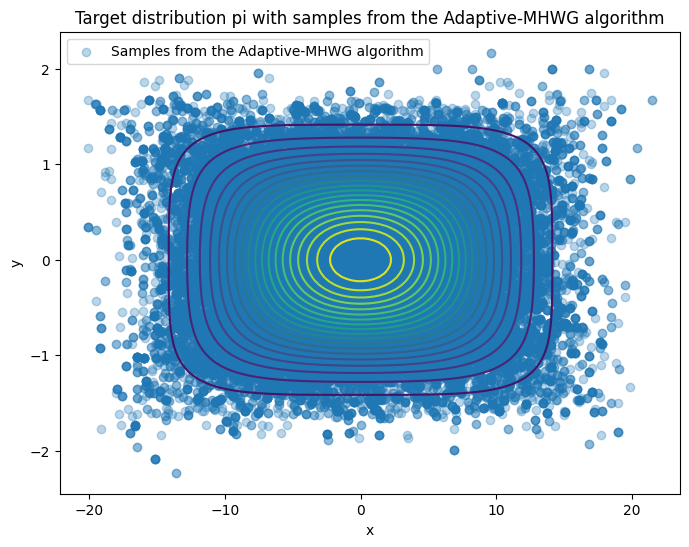

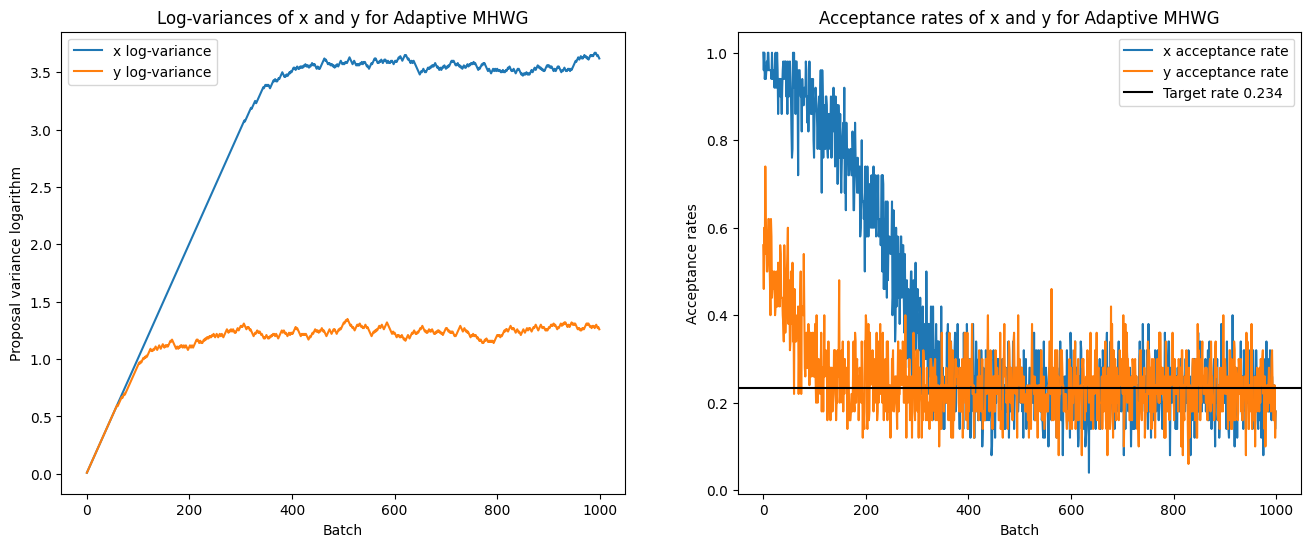

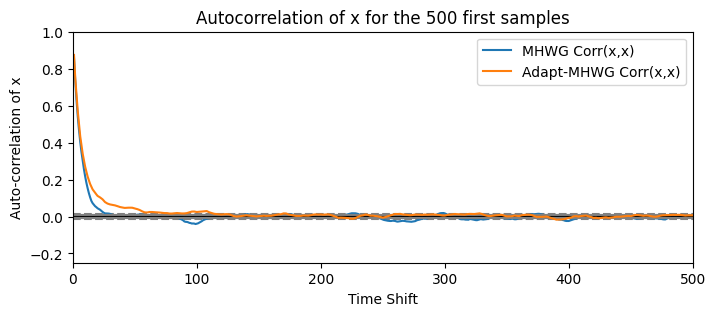

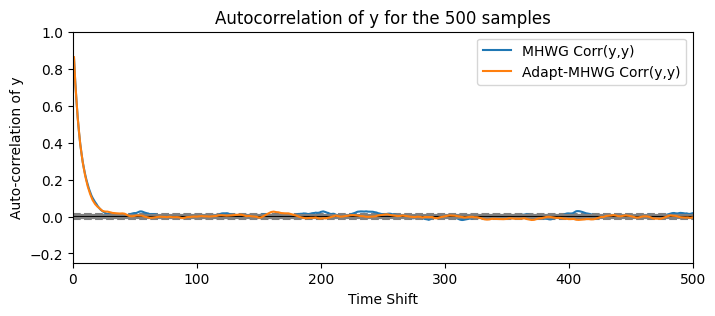

In [439]:
def plot_2():
    x = np.linspace(-20, 20, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.exp(log_pi(X, Y, a))

    # Plot the samples and the target distribution
    plt.figure(figsize=(8,6))
    plt.scatter(Adapt_Samples[:, 0], Adapt_Samples[:, 1], alpha = 0.3, label='Samples from the Adaptive-MHWG algorithm')
    plt.contour(X, Y, Z, cmap='viridis', levels=20)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Target distribution pi with samples from the Adaptive-MHWG algorithm')
    plt.legend()
    plt.show()

    # Plot the log-variances l1 and l2
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(L[:,0], label = "x log-variance")
    plt.plot(L[:,1], label = "y log-variance")
    plt.title("Log-variances of x and y for Adaptive MHWG")
    plt.xlabel("Batch")
    plt.ylabel("Proposal variance logarithm")
    plt.legend()

    # Plot the acceptance rate of x and y
    plt.subplot(1,2,2)
    plt.plot(Adapt_Accepts[:,0], label = "x acceptance rate")
    plt.plot(Adapt_Accepts[:,1], label = "y acceptance rate")
    plt.axhline(y=0.234, color = "black", label="Target rate 0.234")
    plt.title("Acceptance rates of x and y for Adaptive MHWG")
    plt.xlabel("Batch")
    plt.ylabel("Acceptance rates")
    plt.legend()



    # Plot the autocorrelation on x and y for both methods
    dict = {'x':Samples[:,0], 'y':Samples[:,1]}
    dict_adapt = {'x':Adapt_Samples[:,0], 'y':Adapt_Samples[:,1]}
    plt.figure(figsize=(8,3))
    pd.plotting.autocorrelation_plot(pd.DataFrame(dict)['x'],label = 'MHWG Corr(x,x)')
    pd.plotting.autocorrelation_plot(pd.DataFrame(dict_adapt)['x'], label = 'Adapt-MHWG Corr(x,x)')
    plt.xlabel('Time Shift')
    plt.xlim(0, 500)
    plt.ylabel('Auto-correlation of x')
    plt.ylim(-0.25, 1)
    plt.title('Autocorrelation of x for the 500 first samples')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,3))
    pd.plotting.autocorrelation_plot(pd.DataFrame(dict)['y'],label = 'MHWG Corr(y,y)')
    pd.plotting.autocorrelation_plot(pd.DataFrame(dict_adapt)['y'], label = 'Adapt-MHWG Corr(y,y)')
    plt.xlabel('Time Shift')
    plt.xlim(0, 500)
    plt.ylabel('Auto-correlation of y')
    plt.ylim(-0.25, 1)
    plt.title('Autocorrelation of y for the 500 samples')
    plt.legend()
    plt.show()

plot_2()

**Observations and conclusions :**
- The first plot show the samples from Adaptive-MHWG and the target distribution $\pi$. As for non-adaptive MHWG (with correct choice of $\sigma_1 = 10\sigma_2$), the samples seems to follow the target law, without "line effect".
- The acceptance rates on $x$ and $y$ tends to the target rate $23.4\%$ which is what we wanted.
- I compare the auto-correlation of x and y for the 500 first samples obtained with the two methods MHWG (with correct choice of $\sigma_i$ and Adaptive-MHWG). We can see that the convergence of the autocorrolation of x is slower with the Adaptive method. There is no gain on $x$. However, it seems that the auto-correlation on $y$ converges a little bit faster with the Adaptive method.

### Question 2

Let's compare the two methods on a more complicated target density : the "banana"-shaped density.

In [440]:
def log_banana(x, B=0.4):
    x = x.copy()
    x[..., 1] += B * (x[..., 0]**2 - 100)
    d = x.shape[-1]
    G = multivariate_normal(np.zeros(d), np.eye(d))
    return G.logpdf(x)

def banana(x, B=0.4):
    x = x.copy()
    x[..., 1] += B * (x[..., 0]**2 - 100) 
    d = x.shape[-1]
    G = multivariate_normal(np.zeros(d), np.eye(d))
    return G.pdf(x)


Let's rewrite the algorithm MHWG and Adaptive-MHWG so that they can take in argument any target log density (in any dimension d).

In [441]:
def MHWG(log_density, d, Sigmas, n_iter,x0=None):

    Samples = np.zeros((n_iter, d))

    # Initialization
    if x0 is None:
        x = np.random.randn(d)
    else:
        x = x0

    mask = np.eye(d)
    for n in trange(n_iter):
        k = np.random.randint(d)
        z = x + mask[k] * (np.random.randn()*Sigmas[k])
        accept_rate = np.exp(min(0, log_density(z) - log_density(x)))
        if np.random.rand() < accept_rate:
            x = z
        Samples[n] = x

    return Samples

In [442]:
def Adaptive_MHWG(log_density,d, n_batch, batch_size, x0=None):
    Accepts = np.zeros((n_batch, d)) # Nb of time new x (resp y) was accepted for each batch
    Samples = np.zeros((n_batch * batch_size, d))
    L = np.zeros((n_batch, d))

    # Initialization
    if x0 is None:
        x = np.random.randn(d)
    else:
        x = x0

    mask = np.eye(d)
    for j in trange(n_batch):
        # Metropolis-Hastings within Gibbs step
        for k in range(batch_size):
            for i in range(d): # i is the coordinate
                z = x + mask[i] * (np.random.randn()*np.exp(L[j-1,i]))
                accept_rate = np.exp(min(0, log_density(z) - log_density(x)))
                if np.random.rand() < accept_rate:
                    x = z
                    Accepts[j,i] += 1
            Samples[j * batch_size + k] = x
        Accepts[j] /= batch_size

        # Update the variance parameters l1 and l2
        delta = min(0.01, 1/np.sqrt(j+1))
        # Update L
        for i in range(d):
            if Accepts[j,i] > 0.234:
                L[j,i] = L[j-1,i] + delta
            else:
                L[j,i] = L[j-1,i] - delta

    return Samples, Accepts, L

Let's test Adaptive MHWG sampling on the banana density.

In [443]:
# Numerical paramters
B = 0.4
d = 20

# MHWG
n_iter = 5000
Sigmas = np.ones(d)

# Adaptive MHWG
n_batch = 100
batch_size = 50

Banana_Samples = MHWG(log_banana, d, Sigmas, n_iter,x0=None)
Banana_Adapt_Samples, Accepts, L = Adaptive_MHWG(log_banana, d, n_batch, batch_size)

100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


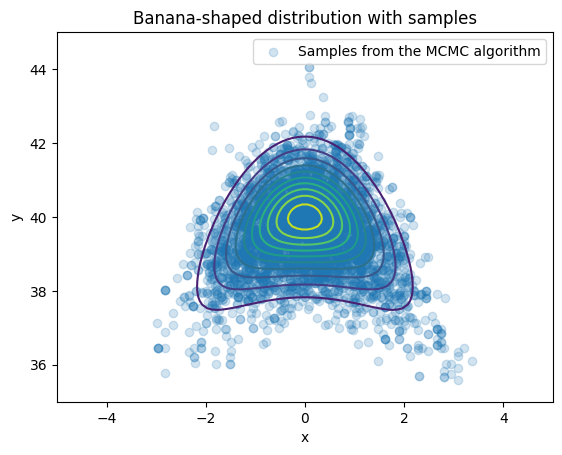

In [444]:
X, Y = np.meshgrid(np.linspace(-5,5,100), np.linspace(35, 45, 100))
XY = np.stack([X,Y]).transpose(1,2,0)

plt.figure()
plt.contour(XY[:,:,0], XY[:,:,1], banana(XY), levels = 10)
plt.scatter(Banana_Adapt_Samples[:,0], Banana_Adapt_Samples[:,1], alpha =0.2, label='Samples from the MCMC algorithm')
plt.xlabel('x')
plt.xlim(-5,5)
plt.ylabel('y')
plt.ylim(35, 45)
plt.title('Banana-shaped distribution with samples')
plt.legend()
plt.show()

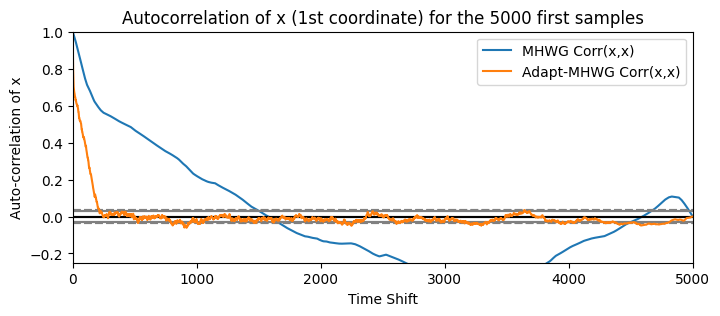

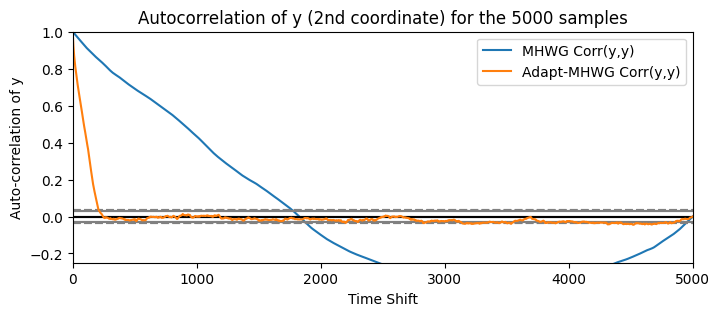

In [445]:
# Plot the autocorrelation on x and y for both methods
def plot_3():
    dict = {'x':Banana_Samples[:,0], 'y':Banana_Samples[:,1]}
    dict_adapt = {'x':Banana_Adapt_Samples[:,0], 'y':Banana_Adapt_Samples[:,1]}
    plt.figure(figsize=(8,3))
    pd.plotting.autocorrelation_plot(pd.DataFrame(dict)['x'],label = 'MHWG Corr(x,x)')
    pd.plotting.autocorrelation_plot(pd.DataFrame(dict_adapt)['x'], label = 'Adapt-MHWG Corr(x,x)')
    plt.xlabel('Time Shift')
    plt.xlim(0, 5000)
    plt.ylabel('Auto-correlation of x')
    plt.ylim(-0.25, 1)
    plt.title('Autocorrelation of x (1st coordinate) for the 5000 first samples')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,3))
    pd.plotting.autocorrelation_plot(pd.DataFrame(dict)['y'],label = 'MHWG Corr(y,y)')
    pd.plotting.autocorrelation_plot(pd.DataFrame(dict_adapt)['y'], label = 'Adapt-MHWG Corr(y,y)')
    plt.xlabel('Time Shift')
    plt.xlim(0, 5000)
    plt.ylabel('Auto-correlation of y')
    plt.ylim(-0.25, 1)
    plt.title('Autocorrelation of y (2nd coordinate) for the 5000 samples')
    plt.legend()
    plt.show()

plot_3()

**Observations and conclusions :**
- The first plot show the sampled points from Adaptive-MHWB (the two first coordinates) and the target "banana"-shaped distribution. It seems that the algorithm is working.
- The 2 next plots show the autocorrelation of $x$ and $y$ for the samples of the two methods MHWG and Adaptive-MHWG. I have run MHWG with $\sigma_i = 1$ for all $i \in {1,..., d}$ which may be not the optimal choice. Indeed, when looking at the autocorrelations, it doesn't seem to converge towards $0$ for $x$ nor for $y$. On the contrary, Adaptive-MHWG's autocorrelations tends "quickly" to $0$ for both two coordinates.

**Therefore in this more complicated problem, Adaptive-MHWG would be a better algorithm.**

# Exercice 2 : Sampling from multimodal distributions

## 2.A A toy example

### Question 1

I implement the target distribution : the gaussian mixture.

Then I implement the two methods SRWMH and Adaptive-SRWMH.

In [446]:
def gaussian_mixture(x, Means, Sigmas, W):
    res = 0
    for i in range(len(Means)):
        res += W[i] * np.exp(-((x-Means[i]).T).dot(x-Means[i])/(2*Sigmas[i]**2)) / (2* np.pi * Sigmas[i]**2)
    return res

In [447]:
def SRWMH(n_iter, Means, Sigmas, W, d=2, sigma_prop = 0.01, x0 = None):
    if x0 == None:
        x = np.random.rand(d)
    else:
        x = x0
    Samples = np.zeros((n_iter, d))
    for n in trange(n_iter):
        z = x + np.random.randn(d) * sigma_prop
        accept_rate = np.exp(min(0, np.log(gaussian_mixture(z, Means, Sigmas, W)) - np.log(gaussian_mixture(x, Means, Sigmas, W))))
        if np.random.rand() < accept_rate:
            x = z
        Samples[n] = x
    return Samples

def Adaptive_SRWMH(n_batch, batch_size, Means, Sigmas, W, d=2, x0 = None):
    if x0 == None:
        x = np.random.rand(d)
    else:
        x = x0
    l = 0
    Samples = np.zeros((n_batch*batch_size, d))
    Accepts = np.zeros((n_batch))
    for n in trange(n_batch):
        for j in range(batch_size):
            z = x + np.random.randn(d) * np.exp(l)
            accept_rate = np.exp(min(0, np.log(gaussian_mixture(z, Means, Sigmas, W)) - np.log(gaussian_mixture(x, Means, Sigmas, W))))
            if np.random.rand() < accept_rate:
                x = z
                Accepts[n]+=1
            Samples[n * batch_size + j] = x
        Accepts[n]/=batch_size

        # Update of log_variance
        delta = min(0.01, 1/np.sqrt(j+1))
        if Accepts[n] > 0.234:
            l += delta
        else:
            l -= delta

    return Samples

### Question 2

Let's evaluate the Metropolis-Hasting Random Walk on the mixture of $20$ Gaussians bellow to test if we can sample from the whole distribution (every mode that are very distant).

In [448]:
# Numerical parameters
d=2

Means = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],[3.93,8.82],[3.25,3.47],[1.70,0.50],
                [4.59,5.60],[6.91,5.81], [6.87,5.40], [5.41,2.65], [2.70,7.88], [4.98,3.70], [1.14,2.39], 
                [8.33,9.50], [4.93,1.50], [1.83,0.09], [2.26,0.31], [5.54,6.86], [1.69,8.11]])
W = np.ones(20)*0.05
Sigmas = np.ones(20)*0.1

n_iter = 5000
batch_size = 50
n_batch = 100

In [449]:
Samples = SRWMH(n_iter, Means, Sigmas, W)
Adapt_Samples = Adaptive_SRWMH(n_batch, batch_size, Means, Sigmas, W )

100%|██████████| 100/100 [00:01<00:00, 53.81it/s]


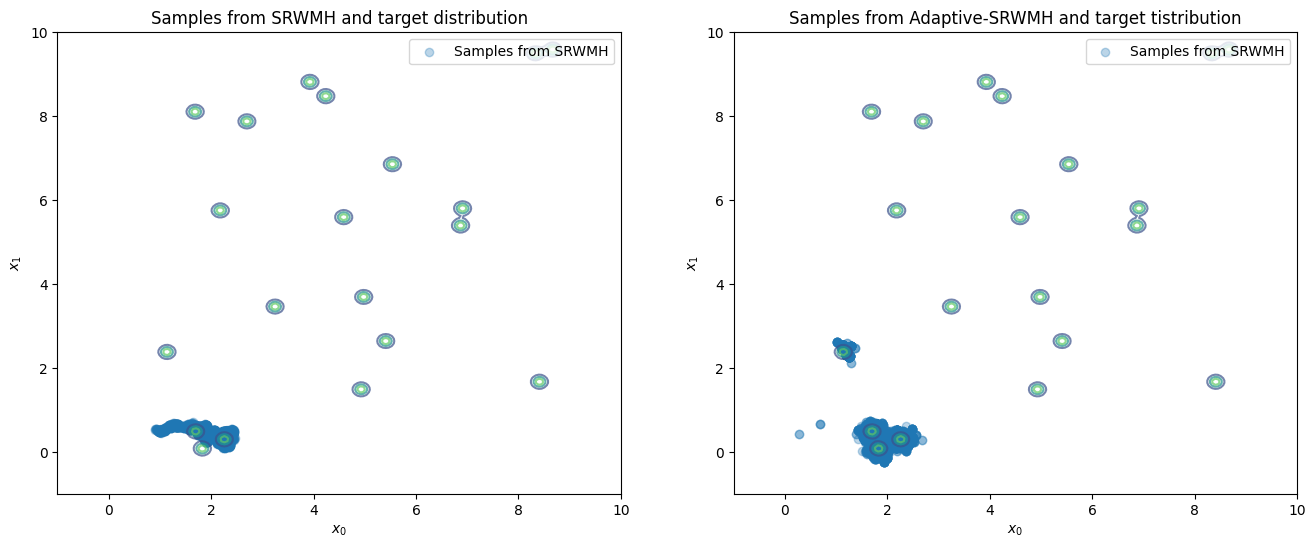

In [450]:
def plot_4():
    X, Y = np.meshgrid(np.linspace(-1, 10, 200), np.linspace(-1, 10, 200))
    XY = np.stack([X.ravel(), Y.ravel()], axis=1)
    Z = np.array([gaussian_mixture(z, Means, Sigmas, W) for z in XY]).reshape(X.shape)

    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.contour(X, Y, Z, levels=3, cmap="viridis", alpha=0.7)
    plt.scatter(Samples[:, 0], Samples[:, 1], alpha=0.3, label="Samples from SRWMH")
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.title("Samples from SRWMH and target distribution")
    plt.legend()

    plt.subplot(1,2,2)
    plt.contour(X, Y, Z, levels=3, cmap="viridis", alpha=0.7)
    plt.scatter(Adapt_Samples[:, 0], Adapt_Samples[:, 1], alpha=0.3, label="Samples from SRWMH")
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.title("Samples from Adaptive-SRWMH and target tistribution")
    plt.legend()
    plt.show()
plot_4()

**Observations and conclusion.**
- We can observe that for SRWMH and Adaptive-SRWMH, the samples do not cover the whole distribution. Indeed, the samples are stucked around few nodes that are close one to each other (and close to the initial point defined as np.random.rand(d)). Adaptive-SRWMH seems to have identified a bit more modes, but not every one of them.

**Thus, the two algorithms fails to sample from the target Gaussian mixture distribution.**

## 2.B Parallel Tempering

### Question 1

Parallel Tempering algorithm is implemented bellow.

In [451]:
def parallel_tempering(d, T, log_pi, n_iter, sigma_prop, X0 = None):
    K = len(T)
    if X0 == None:
        X = np.random.randn(K, d)
    else:
        X = X0
    
    Samples = np.zeros((n_iter, K, d)) # Contains the list of every iteration of the K chains x_i (x_i of dim d)
    Accepts = np.zeros(K)
    jumps = 0
    
    for n in trange(n_iter):
        # Metropolis-Hasting step for all Markov chains {1,...,K}
        for i in range(K):
            z = X[i] + np.random.randn(d) * sigma_prop * 0.25 * np.sqrt(T[i]) 
            accept_rate = np.exp(min(0, log_pi(z)/T[i] - log_pi(X[i])/T[i]))
            if np.random.rand() < accept_rate:
                X[i] = z
                Accepts[i]+=1
        
        # Choice of 2 chains p != q to propose a swap
        p, q  = np.random.choice(np.arange(K), size=2, replace=False) 

        accept_proba = np.exp(min(0, log_pi(X[q])/T[p] + log_pi(X[p])/T[q] - log_pi(X[p])/T[p] - log_pi(X[q])/T[q]))
        if np.random.rand() < accept_proba:
            X[p], X[q] = X[q], X[p]
            jumps += 1
        
        Samples[n] = X
    
    print("Acceptance rates = ", Accepts/n_iter)
    print("Jump rate = ", jumps/n_iter)

    return Samples
    

### Question 2

In [452]:
# Numerical parameters

d = 2
sigma_prop = np.array([1, 1])

K = 5
T = np.array([60, 21.6, 7.7, 2.8, 1])

n_iter = 10000

def log_pi(z,a=10):
    x = z[0]
    y = z[1]
    return -(x/a)**2-y**2-0.25*((x/a)**2-y**2)**2

In [453]:
def log_gaussian_mixture(x, Means = Means, Sigmas = Sigmas, W = W):
    res = 0
    for i in range(len(Means)):
        res += W[i] * np.exp(-((x-Means[i]).T).dot(x-Means[i])/(2*Sigmas[i]**2)) / (2* np.pi * Sigmas[i]**2)
    return np.log(res)

PT_samples = parallel_tempering(d, T, log_gaussian_mixture, n_iter, sigma_prop)

  0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\roman\AppData\Local\Temp\ipykernel_27588\3451799121.py:5: RuntimeWarning: divide by zero encountered in log
  return np.log(res)
100%|██████████| 10000/10000 [00:17<00:00, 569.15it/s]

Acceptance rates =  [0.5111 0.4138 0.2905 0.2563 0.2472]
Jump rate =  0.35


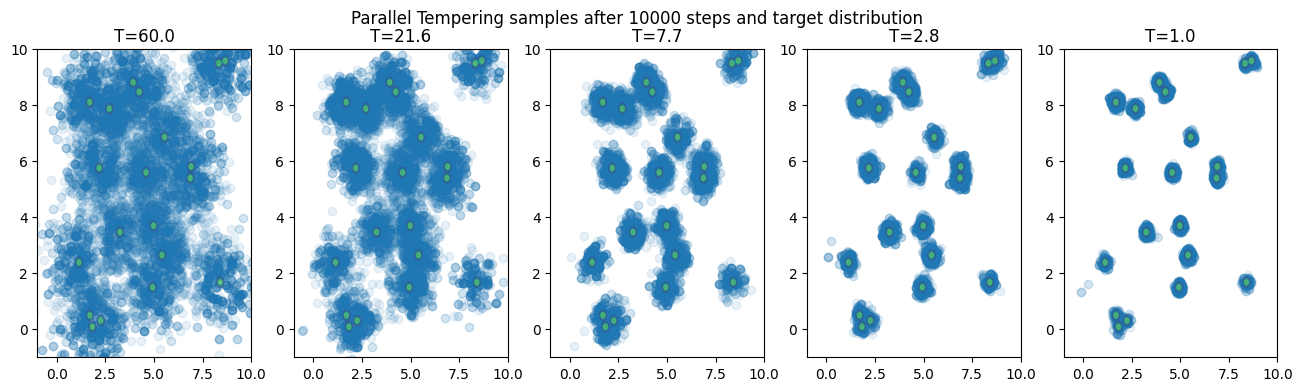

In [454]:
def plot_5():
    X, Y = np.meshgrid(np.linspace(-1, 10, 200), np.linspace(-1, 10, 200))
    XY = np.stack([X.ravel(), Y.ravel()], axis=1)
    Z = np.array([gaussian_mixture(z, Means, Sigmas, W) for z in XY]).reshape(X.shape)

    plt.figure(figsize=(16, 4))
    for i in range(K):
        plt.subplot(1, K, i+1)
        plt.xlim(-1, 10)
        plt.ylim(-1, 10)
        plt.scatter(PT_samples[:,i,0], PT_samples[:,i,1], alpha = 0.1)
        plt.contour(X, Y, Z, levels=3, cmap="viridis", alpha=0.7)
        plt.title(f"T={T[i]}")
    plt.suptitle("Parallel Tempering samples after 10000 steps and target distribution")
plot_5()

**Observations and conclusions :**
- When looking at high temperature $T=60$, the samples cover every modes, but the distribution around each mode is very sparse. Indeed with high temperature, very low values of $\pi(x)$ become much larger with $\pi(x)^{1/T}$. Therefore regions where the density $\pi(x)$ are explored, leading to the exploration of new modes.
- When looking at lower values of temperature, we can see that every modes are explored, which is what we cant. The more $T$ decreases, the less sparse are the samples around the modes. For $T = 1$, which corresponds to the target distribution $\pi$, we have the result that we expect : the samples cover every modes, even when they are well separated (unlikely to juste SRWMH or Adaptive SRWMH).
- Using large temperatures helps exploring other modes when doing swaps between the different Markov Chains, leading to the correct sampling of the target distribution $\pi$ for $T=1$.
- Note that the acceptance rate of $T=1$ is around $24\%$, which is a good value.

**Thus we can conclude that Parallel Tempering enables to sample from multi-modal distributions efficiently.**

# Exercise 3 : Bayesian analysis of a one-way random effects

### Question 1

Answer on the PDF.

### Question 2

The marginal posterior densities $(\mu | X, \sigma^2, \tau^2, Y)$, $(\sigma^2 | X, \mu, \tau^2, Y)$, $(\tau^2 | X, \mu, \sigma^2, Y)$ and $(X_i | \mu, \sigma^2, \tau^2, Y)$ are detailed in the PDF file. Knowing them, we can write the Gibbs sampler as follow.

In [570]:
def Gibbs_sampler(N, Ki, Y, alpha, beta, gamma, n_iter, init=None):
    k = np.sum(Ki)
    if init is None:
        mu = 1.2
        sigma2 = 0.1
        tau2 = 0.8
        X = np.random.normal(1, np.sqrt(0.1), N)
    else:
        mu, sigma2, tau2, X = init

    params = {'mu': [mu], 'sigma2': [sigma2], 'tau2': [tau2]}
    for n in trange(n_iter):
        # Update of mu
        mu = np.random.normal(np.mean(X), np.sqrt(sigma2/N))
        
        # Update of sigma2
        sigma2 = 1/np.random.gamma(alpha + N/2, 1/(beta + 0.5*np.sum([(X[i] - mu)**2 for i in range(N)])))
        
        # Update of tau2
        tau2 = 1/np.random.gamma(gamma + k/2, 1/(beta + 0.5*np.sum([(Y[i,j]-X[i])**2 for i in range(N) for j in range(Ki[i])])))
        
        # Update of X[i]
        for i in range(N):
            var_i = 1/(1/sigma2 + Ki[i]/tau2)
            mean_i = var_i * (np.sum([Y[i,j]/tau2 for j in range(Ki[i])]) + mu/sigma2)
            X[i] = np.random.normal(mean_i, np.sqrt(var_i))
        
        params['mu'].append(mu)
        params['sigma2'].append(sigma2)
        params['tau2'].append(tau2)
    
    return params


### Question 3

In [469]:
def Block_Gibbs_sampler(N, Ki, Y, alpha, beta, gamma, n_iter, init=None):
    k = np.sum(Ki)
    if init is None:
        mu = 1
        sigma2 = 0.1
        tau2 = 0.1
        X = np.random.normal(1, np.sqrt(0.1), N)
    else:
        mu, sigma2, tau2, X = init

    params = {'mu': [mu], 'sigma2': [sigma2], 'tau2': [tau2]}
    for n in trange(n_iter):
               
        # Update of sigma2 and tau2 (as before)
        sigma2 = 1/np.random.gamma(alpha + N/2, 1/(beta + 0.5*np.sum((X-mu)**2)))
        tau2 = 1/np.random.gamma(gamma + k/2, 1/(beta + 0.5*np.sum([(Y[i,j]-X[i])**2 for i in range(N) for j in range(Ki[i])])))
        
        # Update of block (X, mu)
        # Calculation of covariance matrix of (X,mu)
        Sigma_inv = np.zeros((N+1, N+1))
        for i in range(N):
            Sigma_inv[i,i] = 1/sigma2 + Ki[i]/tau2
            Sigma_inv[i,N] = -1/sigma2
            Sigma_inv[N,i] = -1/sigma2
        Sigma_inv[N,N] = N/sigma2
        Sigma = np.linalg.inv(Sigma_inv)

        # Calculation of mean of (X,mu)
        lambd = np.zeros(N+1)
        for i in range(N):
            lambd[i] = np.sum([Y[i,j] for j in range(Ki[i])]) / tau2
        lambd = Sigma.dot(lambd)

        Z = np.random.multivariate_normal(lambd, Sigma)
        X = Z[:N]
        mu = Z[-1]
        
        params['mu'].append(mu)
        params['sigma2'].append(sigma2)
        params['tau2'].append(tau2)
    
    return params


### Question 4

Block-Gibbs sampling is slower at each iteration because of the inversion of the correlation matrix $\Sigma$ of $(X, \mu)$, especially in high dimension $N$ (since the inversion step costs $O(N^2)$). In the following test, $N=100$ is high leading to a slower algorithm for the same number of iterations $n_{iter} = 1000$ as for Gibbs Sampler.

However, Block-Gibbs should provide a faster convergence (in terms of number of iterations) because sampling two variables as a block leads to a bigger step in the space of parameters than updating the parameters "one by one". So theorically, if the dimension is not too large, the Block-Gibbs sampler should be a better algorithm.

In the following, I run a test in a relativerly high dimension $N = 100$, resulting in a slower Block-Gibbs algorithm.

### Question 5

In [517]:
def generate_Y(N, ki, mu, sigma, tau):
    X = np.random.normal(mu, np.sqrt(sigma), N)
    Y = np.array([X[i] + np.random.normal(0, np.sqrt(tau), ki) for i in range(N)])
    return Y

In [591]:
# Numerical parameters 
n_iter = 1000
N = 100
ki = 10
Ki = [10 for i in range(100)] # All ki are equal to 10 

alpha = 2
beta =  3
gamma = 1

mu = 1
sigma = 1 / np.random.gamma(alpha, beta)
sigma2 = sigma**2
tau =  1 / np.random.gamma(gamma, beta)
tau2 = tau**2

Y = generate_Y(N, ki, mu, sigma, tau)

print("Target parameters: mu = %1.3f "%mu + ', sigma2 = %1.3f '%sigma + ', tau2 = %1.3f '%tau2)

Target parameters: mu = 1.000 , sigma2 = 0.420 , tau2 = 0.504 


In [592]:
params = Gibbs_sampler(N, Ki, Y, alpha, beta, gamma, n_iter)
block_params = Block_Gibbs_sampler(N, Ki, Y, alpha, beta, gamma, n_iter)

100%|██████████| 1000/1000 [02:57<00:00,  5.65it/s]


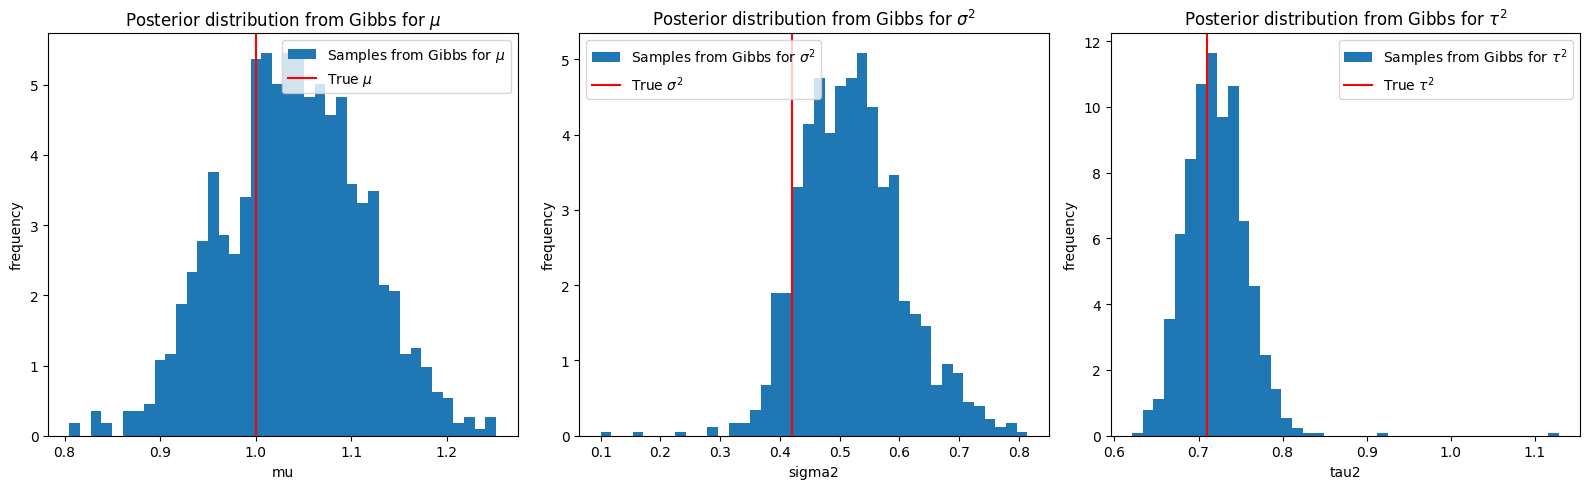

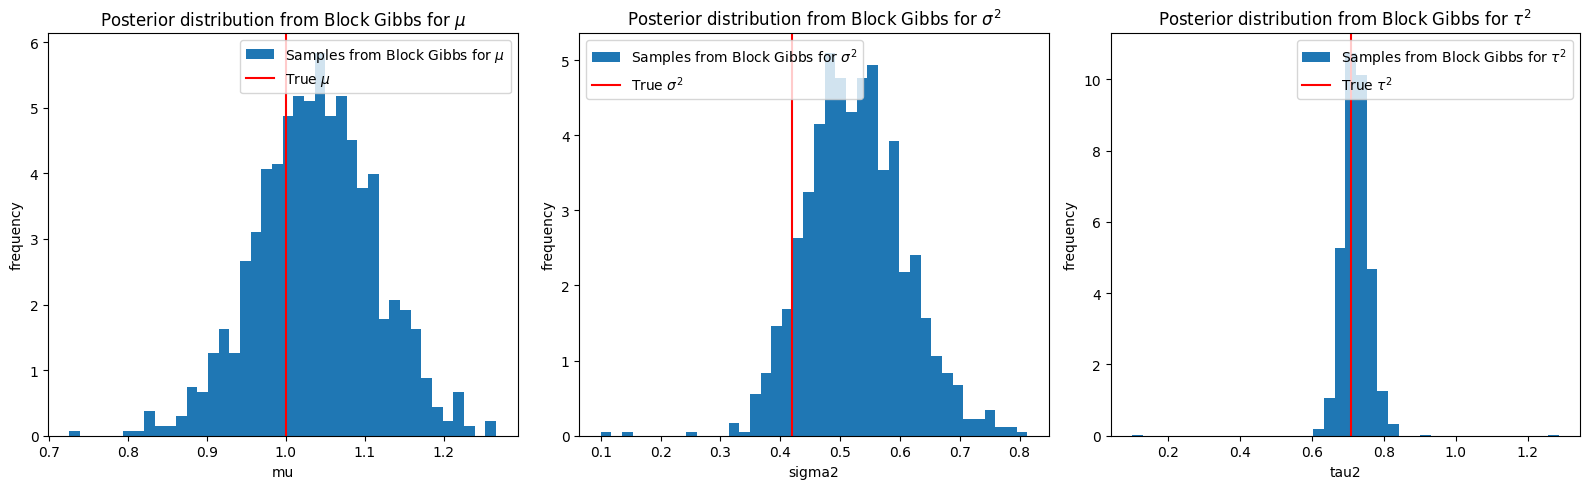

In [595]:
def plot_6():
    plt.figure(figsize=(16, 5))

    #Plot mu samples
    plt.subplot(1, 3, 1)
    plt.hist(params['mu'], bins = 40, density = True, label =r'Samples from Gibbs for $\mu$')
    plt.axvline(mu,color='red' , label = r'True $\mu$')
    plt.title(fr'Posterior distribution from Gibbs for $\mu$')
    plt.xlabel(f'mu')
    plt.ylabel(f'frequency')
    plt.legend()

    #Plot sigma samples
    plt.subplot(1, 3, 2)
    plt.hist(params['sigma2'], bins = 40, density = True, label =r'Samples from Gibbs for $\sigma^2$')
    plt.axvline(sigma, color='red', label = r'True $\sigma^2$')
    plt.title(fr'Posterior distribution from Gibbs for $\sigma^2$')
    plt.xlabel(f'sigma2')
    plt.ylabel(f'frequency')
    plt.legend()

    #Plot tau samples
    plt.subplot(1, 3, 3)
    plt.hist(params['tau2'], bins = 40, density = True, label =r'Samples from Gibbs for $\tau^2$')
    plt.axvline(tau, color='red', label = r'True $\tau^2$')
    plt.title(fr'Posterior distribution from Gibbs for $\tau^2$')
    plt.xlabel(f'tau2')
    plt.ylabel(f'frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()



    plt.figure(figsize=(16, 5))

    #Plot mu samples
    plt.subplot(1, 3, 1)
    plt.hist(block_params['mu'], bins = 40, density = True, label =r'Samples from Block Gibbs for $\mu$')
    plt.axvline(mu,color='red' , label = r'True $\mu$')
    plt.title(fr'Posterior distribution from Block Gibbs for $\mu$')
    plt.xlabel(f'mu')
    plt.ylabel(f'frequency')
    plt.legend()

    #Plot sigma samples
    plt.subplot(1, 3, 2)
    plt.hist(block_params['sigma2'], bins = 40, density = True, label =r'Samples from Block Gibbs for $\sigma^2$')
    plt.axvline(sigma, color='red' , label = r'True $\sigma^2$')
    plt.title(fr'Posterior distribution from Block Gibbs for $\sigma^2$')
    plt.xlabel(f'sigma2')
    plt.ylabel(f'frequency')
    plt.legend()

    #Plot tau samples
    plt.subplot(1, 3, 3)
    plt.hist(block_params['tau2'], bins = 40, density = True, label =r'Samples from Block Gibbs for $\tau^2$')
    plt.axvline(tau, color='red' , label = r'True $\tau^2$')
    plt.title(fr'Posterior distribution from Block Gibbs for $\tau^2$')
    plt.xlabel(f'tau2')
    plt.ylabel(f'frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_6()


**Observations and results :**
- The two algorithms Gibbs and Block-Gibbs samplers enable to sample $(\mu, \sigma^2, \tau^2)$ reasonably well. In both cases, samples for $\tau^2$ are well centered on the target value (and more concentrated around this value for Block-Gibbs sampler).
- Samples of $\mu$ and $\sigma^2$ are not well centered on their target value. This could be because of the choice of the hyper-parameters $(\alpha, \beta, \gamma)$ and the choice of the initial values $(X_0, \mu_0, \sigma_0^2, \tau_0^2)$. Yet after playing with those parameters, I couldn't help ameliorating the sampling.
